In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import random
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np


random.seed(1)

Using TensorFlow backend.


In [2]:
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict = {CT:[], MRI:[], PET:[]}

#creo il dizionario con le liste delle immagini
for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]

#split train:70 validation:20 test:10    
#split train test
CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=0.7)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=0.7)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=0.7)
#split train validation
CT_test, CT_validation = train_test_split(CT_test, train_size=0.3)
MRI_test, MRI_validation = train_test_split(MRI_train, train_size=0.3)
PET_test, PET_validation = train_test_split(PET_train, train_size=0.3)

In [3]:
shutil.rmtree('data/')

In [4]:
#data
print('Creo la directory data/ in questa posizione:', os.getcwd())

directories = ['data/train/', 
               'data/validation/', 
               'data/test/']

#creo le direcotories data/train, data/test
for i in range(3):
        os.makedirs(directories[i])


Creo la directory data/ in questa posizione: /home/phil/Documents/FisicaUniMiB/Tesi/Source/Code


## Datasets

### Overfitting

In [5]:
#dataset to test overfitting
minimum_len = 10
train_file_names = CT_train[0:minimum_len] + MRI_train[0:minimum_len] + PET_train[0:minimum_len]
validation_file_names = CT_validation[0:minimum_len] + MRI_validation[0:minimum_len] + PET_validation[0:minimum_len]
test_file_names = CT_test[0:minimum_len] + MRI_test[0:minimum_len] + PET_test[0:minimum_len]
print('Overfit')

Overfit


### Unbalanced

In [8]:
#run this if you want unbalanced dataset
train_file_names = CT_train + MRI_train + PET_train
validation_file_names = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test
print('Unbalanced.')

Unbalanced.


### Balanced

In [9]:
#run this if you want balanced dataset
minimum_len = min(len(CT_train),len(MRI_train),len(PET_train))        
train_file_names = CT_train[0:minimum_len] + MRI_train[0:minimum_len] + PET_train[0:minimum_len]
validation_file_names = CT_validation[0:minimum_len] + MRI_validation[0:minimum_len] + PET_validation[0:minimum_len]
test_file_names = CT_test[0:minimum_len] + MRI_test[0:minimum_len] + PET_test[0:minimum_len]
print('Balanced.')

Balanced.


In [10]:
print("Number of images before data augmentation. Training:", len(train_file_names),", Validation:", len(validation_file_names), ", Test:", len(test_file_names))

Number of images before data augmentation. Training: 594 , Validation: 412 , Test: 180


## Copio immagini nelle cartelle

In [11]:
scans = ['CT', 'MRI', 'PET']

#copio le immagini di train in data/train
for source,scan in zip(myPaths, scans):
    #train_file_names = eval(scan+'_train')
    for f in train_file_names:
        try:
            shutil.copy(source+f, directories[0])
        except OSError:
            pass
        
#copio le immagini di validation in data/validation
for source,scan in zip(myPaths, scans):
    #validation_file_names = eval(scan+'_validation')
    for f in validation_file_names:
        try:
            shutil.copy(source+f, directories[1])
        except OSError:
            pass
        
#copio le immagini di test in data/test
for source,scan in zip(myPaths, scans):
    #test_file_names = eval(scan+'_test')
    for f in test_file_names:
        try:
            shutil.copy(source+f, directories[2])
        except OSError:
            pass

print("Dati trasferiti con successo.")

Dati trasferiti con successo.


## Data augmentation on train database

In [12]:
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip
    return image_array[::-1, :]

def blured_image(image_array: ndarray):
    return ndimage.uniform_filter(original_image, size=(11, 11, 1))

In [13]:
import random

# our folder path containing some images
folder_path = 'data/train'

# scale of augmentationk
j = 0

# the number of file to generate
num_files_desired = len(train_file_names)*j


# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip}

for i in range(num_files_desired):
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
    
    # random num of transformations to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](image_to_transform)
    
    # define a name for our new file
    new_file_path = '%s_augmented_image_%s.png' % (image_path.split('.')[0], i)
    
    # write image to the disk
    sk.io.imsave(new_file_path, transformed_image)
    
    #from IPython.core.debugger import set_trace
    #set_trace()

## Converto le immagini in tensori

In [14]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

# lista per fare image reading
final_train_file_names = [os.path.join(directories[0], f) for f in os.listdir(directories[0]) if os.path.isfile(os.path.join(directories[0], f))]
final_validation_file_names = [os.path.join(directories[1], f) for f in os.listdir(directories[1]) if os.path.isfile(os.path.join(directories[1], f))]
final_test_file_names = [os.path.join(directories[2], f) for f in os.listdir(directories[2]) if os.path.isfile(os.path.join(directories[2], f))]

print("Database dimension after data augmentation. Training:", len(final_train_file_names), ", Validation:", len(final_validation_file_names) ,", Test:", len(final_test_file_names))

Database dimension after data augmentation. Training: 594 , Validation: 412 , Test: 180


### Images (x)

(594, 128, 128)


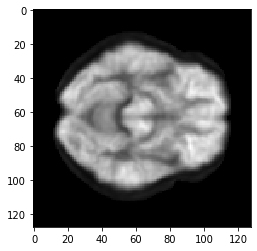

In [19]:
#x_train --------------------------------------------------------------------------
x_train = io.imread(final_train_file_names[random.randint(0,9)]) #iniziallizza
x_train = cv2.resize(x_train, dsize=(128,128)) #resize

#stack images
for img in final_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_train = np.dstack((x_train,img))

x_train = np.rollaxis(x_train,-1) #(182,128,N)->(N,182,128)


#x_validation ----------------------------------------------------------------------
x_validation = io.imread(final_validation_file_names[random.randint(0,9)])
x_validation = cv2.resize(x_validation, dsize=(128,128))

#stack images
for img in final_validation_file_names[1:]: 
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_validation = np.dstack((x_validation,img))

x_validation = np.rollaxis(x_validation,-1) 


#x_test ----------------------------------------------------------------------------
x_test = io.imread(final_test_file_names[random.randint(0,9)])
x_test = cv2.resize(x_test, dsize=(128,128))

#stack images
for img in final_test_file_names[1:]: 
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_test = np.dstack((x_test,img))

x_test = np.rollaxis(x_test,-1) 

print(x_train.shape)
#plot
plt.imshow(x_test[0], cmap=plt.cm.gray)

### Labels (y)

In [16]:
#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_train = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y_train.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_train):
    if item == 'CT':
        y_train[i] = 0
    elif item == 'MRI':
        y_train[i] = 1
    else: y_train[i] = 2        

#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_validation = []
for text in listdir('data/validation'):
    fileNameOnly = text[:text.find(ext)]
    y_validation.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_validation):
    if item == 'CT':
        y_validation[i] = 0
    elif item == 'MRI':
        y_validation[i] = 1
    else: y_validation[i] = 2  
    

#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_test = []
for text in listdir('data/test'):
    fileNameOnly = text[:text.find(ext)]
    y_test.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_test):
    if item == 'CT':
        y_test[i] = 0
    elif item == 'MRI':
        y_test[i] = 1
    else: y_test[i] = 2  


### Tensori

In [18]:
#preparo i tensori per passarli all'autoencoder

#preparo il dataset di train
x = np.concatenate((x_train,))      
y = np.concatenate((y_train,))

x = x.reshape(x.shape + (1,))
x = x/255.
print('x shape:', x.shape)
print('y shape:', y.shape)

#preparo il dataset di validation
x_validation = x_validation.reshape(x_validation.shape + (1,))
x_validation = x_validation/255.
print(x_validation.shape)

#preparo il dataset di test
x_test = x_test.reshape(x_test.shape + (1,))
x_test = x_test/255.

#numero di clusters
n_clusters = len(np.unique(y))
print('Number of categories:', n_clusters)

(594, 128, 128, 1)
x shape: (594, 128, 128, 1)
y shape: (594,)
(412, 128, 128, 1, 1)
Number of categories: 3


## Pretrain a convolutional autoencoder

In [11]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Modello AE Conv2D_1

In [12]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 2048]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [13]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
embedding (Dense)            (None, 2048)              67110912  
__________________________________________________________

### Pretrain


In [14]:
#hyperparameters
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)

pretrain_epochs = 20
batch_size = 8

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

tensorboard --logdir=/tmp/autoencoder



In [15]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(x, 
                x, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_validation, x_validation),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 30 samples
Epoch 1/20
30/30 [==============================] - 9s 289ms/step - loss: 0.0972 - val_loss: 0.1025
Epoch 2/20
30/30 [==============================] - 8s 275ms/step - loss: 0.0916 - val_loss: 0.0947
Epoch 3/20
30/30 [==============================] - 10s 347ms/step - loss: 0.0830 - val_loss: 0.0825
Epoch 4/20
30/30 [==============================] - 10s 317ms/step - loss: 0.0716 - val_loss: 0.0708
Epoch 5/20
30/30 [==============================] - 10s 325ms/step - loss: 0.0640 - val_loss: 0.0665
Epoch 6/20
30/30 [==============================] - 9s 296ms/step - loss: 0.0613 - val_loss: 0.0643
Epoch 7/20
30/30 [==============================] - 11s 358ms/step - loss: 0.0610 - val_loss: 0.0645
Epoch 8/20
30/30 [==============================] - 8s 271ms/step - loss: 0.0605 - val_loss: 0.0638
Epoch 9/20
30/30 [==============================] - 10s 325ms/step - loss: 0.0605 - val_loss: 0.0636
Epo

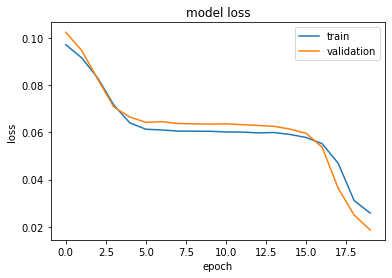

In [16]:
#plot train and validation loss of pretraining
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

In [19]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])

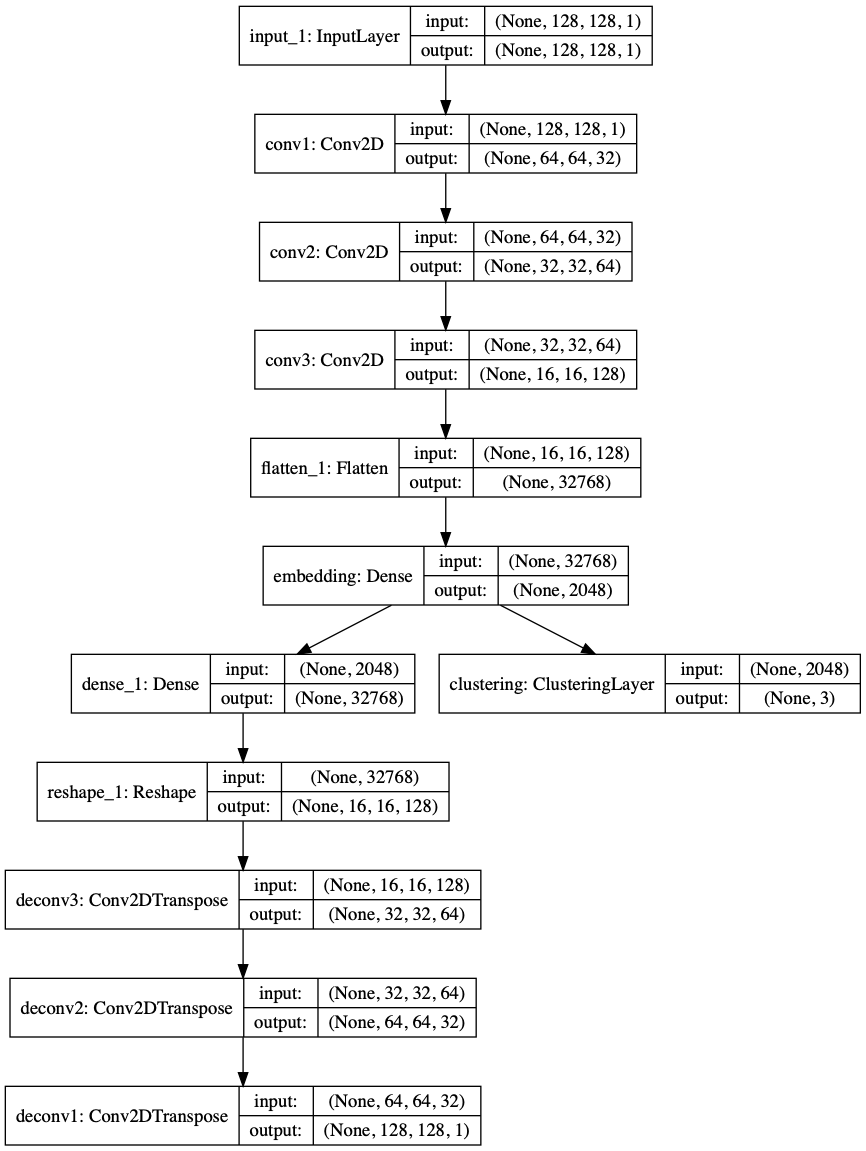

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [21]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [22]:
output_cluster = model.predict(x)[0]
print(output_cluster.shape)
y_pred = kmeans.fit_predict(model.predict(x)[0])

(30, 3)


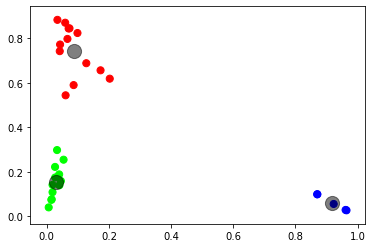

In [23]:
plt.scatter(output_cluster[:,0], output_cluster[:,1], c=y_pred, s=50, cmap='brg')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5);

### Bokeh

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10_10
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 
from io import BytesIO
from PIL import Image
import base64
def embeddable_image(data):
    data = data[:,:,0]
    buffer = BytesIO()
    plt.imsave(buffer, data, cmap='gray')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [ ]:
import pandas as pd

emb = model.predict(x_validation)[0]
digits_df = pd.DataFrame(emb, columns=('x', 'y', 'z'))
digits_df['labels'] = [str(i) for i in y_validation]
digits_df['image'] = list(map(embeddable_image, list(x_validation)))
#digits_df['image_name'] = [dset_train.x_name[i] for i in range(len(dset_train))]
digits_df = digits_df
datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=['0', '1', '2'],
                                       palette=Category10_10)
plot_figure = figure(
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 1px 1px 1px 1px'/>
    </div>
    <div>
        <span style='font-size: 13px'>@labels</span>
    </div>
</div>
"""))
plot_figure.circle(
    'x',
    'y',
    source=ColumnDataSource(digits_df),
    color=dict(field='labels', transform=color_mapping)
    )
plot_figure.cross(
    x=centers[:,0],
    y=centers[:,1],
    size=20,
    line_width=2
)

#plot_figure.legend.location = "top_left"
#plot_figure.legend.click_policy="hide"
show(plot_figure)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

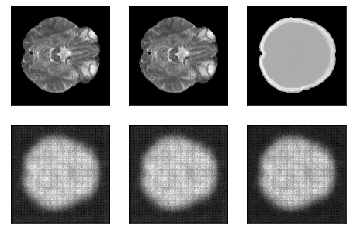

In [24]:
#predict images and display

n=3
decoded_imgs = autoencoder.predict(x_test)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep clustering

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
val_loss = 0
index = 0
maxiter = 20000
update_interval = 140
index_array = np.arange(x.shape[0])
index_array_val = np.arange(x_validation.shape[0])

tol = 0.001 # tolerance threshold to stop training

## Training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            val_loss = np.round(val_loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss, '; val loss=', val_loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])

    idx_val = index_array_val[index * batch_size: min((index+1) * batch_size, x_validation.shape[0])]
    val_loss = model.test_on_batch(x=x_validation[idx_val], y=[p[idx_val], x_validation[idx_val]])
    
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

In [ ]:
#plot train and validation loss of pretraining
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [ ]:
#eval
q, _ = model.predict(x_test, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
#confusion matrix
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)

confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind

In [ ]:
#predict images and display
n=3
decoded_imgs = autoencoder.predict(x_test)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()